# Statistics

Statistics is widely used in financial modeling and analysis. We use statistical discoveries to build and implement models that better price derivatives and anticipate stock price movement. We will discuss the following selected topics in the filed of statistics that are most relevant to our project.  


* Normality tests
* Portfolio theory
* Principal component analysis (PCA)
* Bayesian regression


In [121]:
import numpy as np
np.random.seed(1000)
import scipy.stats as sc
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymc as pm
%matplotlib inline

### Normality Tests

The normal distribution is one of the most important distributions in finance. A great number of financial theories are based on normal distribution to a large extent. Specifically for option pricing theory, Black–Scholes model uses a geometric Brownian motion to model stock’s random fluctuations over time, leading to normally distributed returns.
We first look at the characteristics of paths from a geometric Brownian motion. 

Suppose we have a geometric Brownian motion S. The log returns $\log \frac{S_t}{S_s} = \log S_t - \log S_s$ between two times $0 < s < t$ are normally distributed. 
The values $S_t$ are log-normally distributed at any time $t > 0$. 

We define a function 'generate_paths' to generate paths for the geometric Brownian motion using Monte Carlo as below. We simulate the level of stock index $S_t$ at a future date $t$ given a level $S_{t-\Delta t}$ at date $t-\Delta t$ in Black–Scholes setup according to:
$$ S_t = S_{t-\Delta t} exp((r - \frac{1}{2} \sigma^2)\Delta t + \sigma \sqrt{\Delta t} z_t)$$


In [53]:
'''
 ---------------------------
 S_0: initial stock value
 t: final time; 
 r: constant short rate
 M: number of time intervals; 
 N: number of paths simulated
 ----------------------------
'''
def generate_paths(S_0, r, sigma, t, M, N):
    # initialize paths to be returned
    paths = np.zeros((M+1, N))
    paths[0] = S_0
    delta = t*1.0 / M
    
    for i in range(1, M+1):
        # simulate z_t from standard normal
        z_t = np.random.standard_normal(N)
        z_t = (z_t - np.mean(z_t)) / np.std(z_t)
        paths[i] = paths[i-1] * np.exp((r - (1/2)*sigma**2) * delta + sigma*np.sqrt(delta) * z_t)
    
    return paths

In [47]:
S_0=100; r=0.06; sigma=0.2; t=1.0; M=60; N=200000
paths = generate_paths(S_0=S_0, r=r, sigma=sigma, t=t, M=M, N=N)

We plot the first 10 simulated paths of geometric Brownian motion over 60 time intervals.

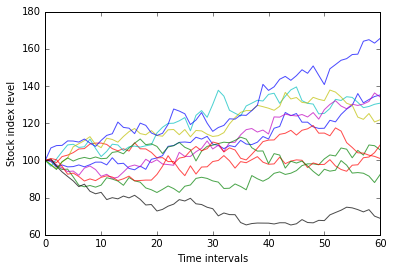

In [119]:
plt.plot(paths[:,:10], alpha=0.7)
plt.xlabel("Time intervals")
plt.ylabel("Stock index level")

We calculate the log returns.

In [49]:
log_returns = np.log(paths[1:] / paths[0:-1])

In [50]:
log_returns[:,0].round(3)

array([-0.005, -0.031,  0.012, -0.011,  0.002,  0.009, -0.011,  0.012,
        0.014,  0.   , -0.015,  0.039, -0.033,  0.003, -0.029, -0.008,
        0.021, -0.018,  0.055,  0.007,  0.012,  0.048,  0.004,  0.016,
        0.002, -0.003,  0.026, -0.009,  0.013, -0.038, -0.006, -0.017,
        0.015, -0.006,  0.032, -0.018, -0.002,  0.012,  0.028, -0.012,
        0.051,  0.008,  0.062, -0.014,  0.009, -0.038,  0.   , -0.021,
       -0.007,  0.001,  0.036, -0.007,  0.032,  0.023,  0.016,  0.047,
       -0.037,  0.013,  0.012,  0.006])

The mixture of postive and negative values in the log returns series above makes sense in financial market, in that we sometimes make positive returns and other times lose money on our investment. 

We now define a function 'print_stats' to print the statistics of an array of values:
size, mean, standard deviation, min, max, skew and kurtosis (a measure of the "tailedness" of the probability distribution)

In [51]:
def print_stats(arr):
    # use describe function from scipy.stats
    stats = sc.describe(arr)
    print "Statistics", "Value"
    print "-------------------"
    print "size", stats[0]
    print "mean", stats[2]
    print "std", np.sqrt(stats[3])
    print "min", stats[1][0]
    print "max", stats[1][1]
    print "skew", stats[4]
    print "kurtosis", stats[5]

In [52]:
print print_stats(log_returns.flatten()) # log_returns: (60, 200,000)

Statistics Value
-------------------
size 12000000
mean 0.001
std 0.0258198900505
min -0.131349887893
max 0.140716581832
skew -0.000804872377121
kurtosis -0.000861588384965
None


The 12,000,000 log return values lie between -0.13 and 0.14. Since these values are from the 60 time intervals, the expected mean of log return over a year is roughly 0.006. 


#### Compare Histogram of Simulations with Normal PDF

We compare the histogram of our simulated log returns with the probability density function of the normal distribution with mean $\frac{r}{M}$ and standard deviation $\frac{\sigma}{\sqrt M}$

In [115]:
def simulations_VS_normal(arr, mu, std):
    plt.hist(arr, bins=50, normed=True, color='b', alpha=0.5, label="Simulations")
    # create x according to the x range of hist
    x = np.linspace(plt.axis()[0], plt.axis()[1])
    plt.plot(x, sc.norm.pdf(x, loc=mu, scale=std), color='r', lw=2.0, label='Normal pdf')
    plt.xlabel('Log-returns')
    plt.ylabel('Frequency')
    plt.legend()

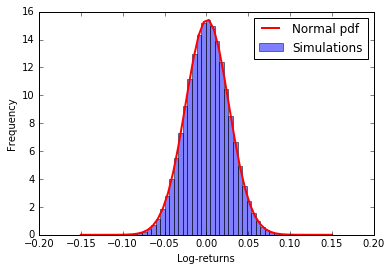

In [116]:
simulations_VS_normal(log_returns.flatten(), r/M, sigma/np.sqrt(M))

#### Q-Q Plot

In statistics, a Q-Q plot is used to compare two probability distributions by plotting their quantiles against each other. In our case, to check the normality of our simulations, we perform Q-Q plot comparing the sample quantile values with the theoretical quantile values. 

In [85]:
def qq_plot(arr):
    sm.qqplot(arr, line='s')
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Simulated quantiles')
    plt.legend()

/Users/xinyanhan/Documents/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


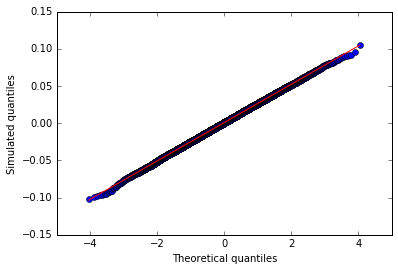

In [86]:
qq_plot(log_returns.flatten()[::300])

We observed from above Q-Q plot that the majority of points lie on the straight line, meaning the theoretical and our simulated distributions are linearly related. 


#### Normality Test

After the above graphical approaches of comparing histogram of simulations and theoretical pdf, and performing Q-Q plot, we use a more rigorous procedure to test normality. In the function 'normality_test' below, we test whether the skew and kurtosis of the sample data are normal, and use 'sc.normaltest' to test normality. 

In [91]:
'''
 scipy.stats.normaltest: Tests whether a sample differs from a normal distribution
 scipy.stats.skewtest: Tests whether the skew is different from the normal distribution
 scipy.stats.kurtosistest: Tests whether a dataset has normal kurtosis
'''
def normality_test(arr):
    print "Skew of data set: ", sc.skew(arr)
    print "P-vale of skew test: ", sc.skewtest(arr)[1]
    print "Kurtosis of data set: ", sc.kurtosis(arr)
    print "P-value of kurtosis test: ", sc.kurtosistest(arr)[1]
    print "P-value of Normality test: ", sc.normaltest(arr)[1]

In [92]:
normality_test(log_returns.flatten())

Skew of data set:  -0.000804872377121
P-vale of skew test:  0.255011113639
Kurtosis of data set:  -0.000861588384965
P-value of kurtosis test:  0.542897379101
P-value of Normality test:  0.434778658196


Since the p-values are all above 0.05, we conclude the log returns are normally distributed. 


Now we test whether the values of last time interval are normally distributed. Similar to the procedure above, we first print the statistics of values in original scale and log scale. We then compare the histogram of our simulated values with the pdf of normal distribution, and perform Q-Q plot. Finally, we apply the 'normality_test' defined above. 

In [98]:
end_paths = paths[-1]
log_endpaths = np.log(end_paths)
print "Statistics of values on original scale: "
print 
print_stats(end_paths)

Statistics of values on original scale: 

Statistics Value
-------------------
size 200000
mean 108.329232189
std 21.8883207004
min 42.6728880865
max 258.198077223
skew 0.61404324671
kurtosis 0.661434706744


In [99]:
print "Statistics of values on log scale: "
print 
print_stats(log_endpaths)

Statistics of values on log scale: 

Statistics Value
-------------------
size 200000
mean 4.66517018599
std 0.200017209301
min 3.75356377915
max 5.55372703154
skew 0.00110528055179
kurtosis 0.00236567003775


Compare the histogram of our simulated values with the pdf of normal distribution


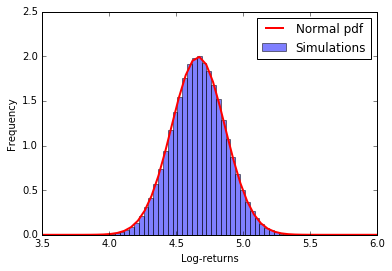

In [117]:
print "Compare the histogram of our simulated values with the pdf of normal distribution"
mu=np.mean(log_endpaths)
std=np.std(log_endpaths)
simulations_VS_normal(log_endpaths, mu, std)

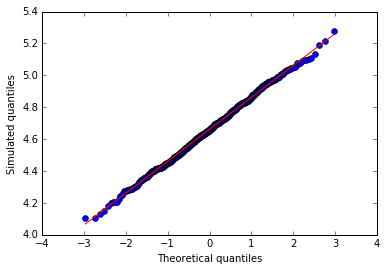

In [102]:
qq_plot(log_endpaths.flatten()[::300])

In [103]:
normality_test(log_endpaths.flatten())

Skew of data set:  0.00110528055179
P-vale of skew test:  0.840070578302
Kurtosis of data set:  0.00236567003775
P-value of kurtosis test:  0.822814522325
P-value of Normality test:  0.955582862877


The high p-values support the hypothesis of normal distribution. The histogram of our simulations approximates the normal pdf pretty well. The Q-Q plot also shows the log stock index levels are normally distributed. 

test with real world data?

### Bayesian Regression

Beyesian regression is heavily used in finance. 
Bayes's formula is written as:
$$ p(D|\Theta) = \frac{p(D) p(\Theta|D)} {p(\Theta)} $$
where $p(D)$ is the prior probability, $p(\Theta)$ is the probability for the data under any hypothesis, $p(\Theta|D)$ is the likelihood of data under hypothesis H, and $p(D|\Theta)$ is the posterior probability. 

We use PyMC to implement a simple example of Bayesian statistics. 

In [120]:
x = np.linspace(0, 20, 500)
y = 5 + (3/2) * x + np.random.standard_normal(len(x)) * 2

In [132]:
#with pm.Model() as model:
# define priors
alpha = pm.Normal('alpha', mu=0, tau=1/15)
beta = pm.Normal('beta', mu=0, tau=1/15)
sigma = pm.Uniform('sigma', lower=0, upper=10)
# define linear regression
y_est = alpha + beta * x
# define likelihood
likelihood = pm.Normal('y', mu=y_est, tau=1/sigma, observed=y)







# inference
start = pm.find_MAP()
# find starting value by optimization
step = pm.NUTS(state=start)
# instantiate MCMC sampling algorithm
trace = pm.sample(100, step, start=start, progressbar=False)



ZeroProbability: Stochastic alpha's value is outside its support,
 or it forbids its parents' current values.